In [13]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [1]:
import os
from ipywidgets import *
import tensorflow
import numpy as np
from numba import jit,f8
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
#testing
def data_generator(data):
    '''
    input : data dictionary (batch number :5D tensor data)
    output: input , target values
    '''
    batches = len(data.keys())
    batch_size = len(data['0'])
    batch_counter= 0
    
    while True:
        x,y = data[f'{batch_counter}'][:,:-1,:,:,:],data[f'{batch_counter}'][:,-1:,:,:,:]
        batch_counter += 1
        yield x,y
        if batch_counter == batches:batch_counter = 0

## Choose Model

In [9]:
import os
thisdir = 'HeatModels'
models = []
loaded_model =''
for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith(".h5"):
            models.append(os.path.join(r, file))

@interact(models=models)
def load_model(models):
    global loaded_model 
    loaded_model = tensorflow.keras.models.load_model(models)
    print(f'{models} loaded !!')

interactive(children=(Dropdown(description='models', options=('HeatModels/Step=10/12x12/step=100 12x12 loss=9e…

## Choose Test data

In [100]:
import os
import pickle
thisdir = 'TestData'
tests = []
loaded_test = ''
for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith(".pkl"):
            tests.append(os.path.join(r, file))

@interact(tests=tests)
def load_data(tests):
    global loaded_test 
    loaded_test = pickle.load(open(tests,'rb'))
    print(f'{tests} loaded !!')

interactive(children=(Dropdown(description='tests', options=('TestData/Step=10/test_12x12_step=10.pkl', 'TestD…

## Choose Logs

In [119]:
import matplotlib.pyplot as plt
# import torch
import tensorflow
import numpy as np
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

mpl.rcParams['figure.dpi'] = 72
mpl.rcParams.update({'font.size': 35})
mpl.rcParams['axes.linewidth'] = 2
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 

In [104]:
import os
import pickle
thisdir = 'HeatModels'
logs_paths=[]
e = [] 
size =12 ; P =10
for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith(".log"):
            logs_paths.append(os.path.join(r, file))

@interact(logs=logs_paths)
def load_data(logs=logs_paths):
    global e , size,P
    
    size = int(logs[-6:-4])
    try : P = int(logs[-13:-10]) ; 
    except : P = int(logs[-12:-10])
        
    with open(logs,"r") as file :
        next(file)
        e = []
        for line in file:
            e.append(list(map(float,line.split(','))))
    print(f'{logs} loaded !')

interactive(children=(Dropdown(description='logs', options=('HeatModels/Step=10/12x12/train step=10 12x12.log'…

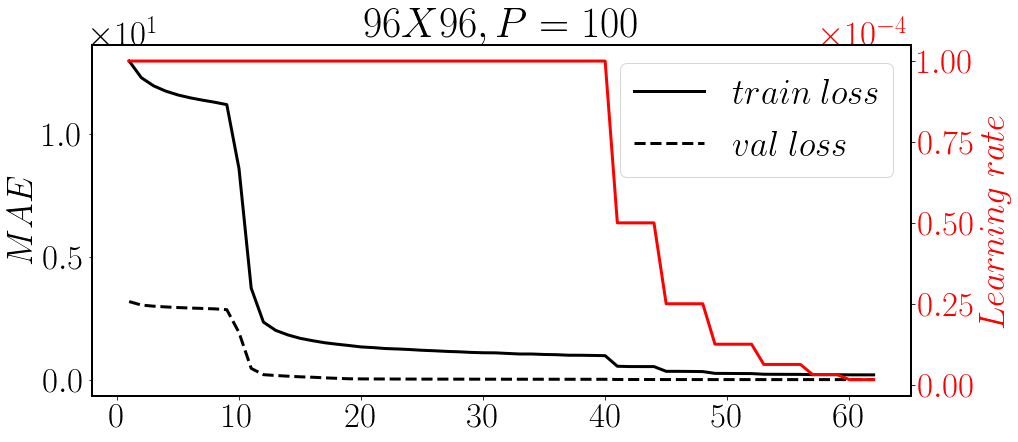

In [133]:
epochs,mae,lr,mae_val =np.array(list(zip(*e[1:]))[0]) ,np.array(list(zip(*e[1:]))[1]),np.array(list(zip(*e[1:]))[2]),np.array(list(zip(*e[1:]))[3])
fig, ax1 = plt.subplots(figsize=(15,7))
ax1.title.set_text(f'${size} X {size} , P = {P}$')

ax1.plot( epochs,mae*250,'-k',linewidth=3)
ax1.plot( epochs,mae_val*250,'--k',linewidth=3)
ax1.tick_params(axis='y', labelcolor='black')
ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax1.set_ylabel('$MAE$', color='black') 

ax2 = ax1.twinx()  
ax2.set_ylabel('$Learning  \ rate$', color='red')  
ax2.plot(epochs, lr,'-r',linewidth=3)
ax2.tick_params(axis='y', labelcolor='red')
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax1.legend([f'$train \  loss $','$val\ loss$'],loc='upper right')
# ax2.legend(['ss'],loc='center right')

fig.savefig(f'{size}x{size} step={P} loss plot.svg')

## Test 

In [78]:
print(f'Data Mean={np.mean( [ [np.mean(( loaded_test[batch] * 250 ) + 500)] for batch in loaded_test])}') 
print(f'Data std= {np.mean( [ [np.std(( loaded_test[batch] * 250 ) + 500)] for batch in loaded_test] )}') 
print(f'MAE={np.array(loaded_model.evaluate(data_generator(loaded_test),steps=len(loaded_test)))[0] * 250}')

Data Mean=501.12811279296875
Data std= 135.8619384765625
1000/1000 [==============================] - 19s 16ms/step - loss: 0.0248 - mse: 0.0054
MAE=6.20200764387846


## Visualize

In [4]:
@jit(nopython=True)
def generate_grid(n,bc,ic=0):
    #n=> Number of interior nodes

    A = np.ones((n+2,n+2),dtype=np.float32) * ic
    A[0,0]=A[-1,-1]=A[0,-1]=A[-1,0]=0
    A[0,1:-1]=bc[2]    # switch the top and bottom wall since we start the iterations from top
    A[1:-1,-1]=bc[1]
    A[-1,1:-1]=bc[0]
    A[1:-1,0]=bc[3]

    return A

@jit(nopython=True)
def update_grid_col(grid,x,n):
    #first half step update
    #x col values ;
    #n col number 
    grid[1:-1,n] = x
    return grid

@jit(nopython=True)
def update_grid_row(grid,x,n):
    #second half step update
    #x row values ;
    #n col number 
    grid[n,1:-1] = x
    return grid

@jit(nopython=True)
def calculate_first_half(A,i,j,lam):
    #calculate the ADI explicit part of the equation first half step
    if j==1 :
        return  lam * A[j][i-1] + 2 *(1-lam) * A[j][i] + lam * A[j][i+1] + lam * A[j-1][i]
    elif j== A.shape[0]-2 :
        return  lam * A[j][i-1] + 2 *(1-lam) * A[j][i] + lam * A[j][i+1] + lam * A[j+1][i]
    else  :
        return  lam * A[j][i-1] + 2 *(1-lam) * A[j][i] + lam * A[j][i+1]

@jit(nopython=True)
def calculate_second_half(A,i,j,lam):
    #calculate the ADI explicit part of the equation second half step
    if i==1 :
        return  lam * A[j-1][i] + 2 *(1-lam) * A[j][i] + lam * A[j+1][i] + lam * A[j][i-1]
    elif i== A.shape[0]-2 :
        return  lam * A[j-1][i] + 2 *(1-lam) * A[j][i] + lam * A[j+1][i] + lam * A[j][i+1]
    else  :
        return  lam * A[j-1][i] + 2 *(1-lam) * A[j][i] + lam * A[j+1][i]

@jit(nopython=True)
def generate_TDM(Lambda,N=3):
    a = np.ones(N-1,dtype=np.float32)*-Lambda 
    b =np.ones(N,dtype=np.float32) * 2*(Lambda+1) 
    return a,b,a

@jit(f8[:](f8[:],f8[:],f8[:],f8[:]))
def TDMA_solver(a0,b0,c0,d0):
    a =np.copy(a0)
    b =np.copy(b0)
    c =np.copy(c0)
    d =np.copy(d0)
    ld = len(d)

    for i in range(1,ld):
        w    = a[i-1]/b[i-1]
        b[i] = b[i]- w * c[i-1]
        d[i] = d[i] -w * d[i-1]
    
    R=b
    R[-1]=d[-1]/b[-1]
    
    for i in range(ld-2,-1,-1):
        R[i]= (d[i]-c[i]*R[i+1]) /b[i]
        
    return R

@jit(nopython=True)
def ADI_first_half_step(grid,Lambda,a,b,c):
    #apply ADI for single step

    N = grid.shape[0]

    ##First half step
    for i in range(1,N-1):

        # initialize explicit side of equation to zeros
        d = np.zeros((N-2))

        #move vertically implcitly and calculate horizontally explicitly
        for j in range(1,N-1):
            d[j-1] =calculate_first_half(grid,i,j,Lambda)

        x = TDMA_solver(a,b,c,d)

        grid = update_grid_col(grid,x,i)

    return grid

@jit(nopython=True)
def ADI_second_half_step(grid,Lambda,a,b,c):
    #apply ADI for single step

    N = grid.shape[1]

    ##Second half step
    for i in range(1,N-1):

        # initialize explicit side of equation to zeros
        d = np.zeros((N-2))

        #move horizontally implcitly and calculate vertically explicitly
        for j in range(1,N-1):
            d[j-1] =calculate_second_half(grid,j,i,Lambda)

        x = TDMA_solver(a,b,c,d)

        grid = update_grid_row(grid,x,i)

    return grid

@jit(nopython=True)
def solve(grid,Lambda=1,iters=1,steps=False) :
    if steps :
        #save intermeidate steps

        #(frames,height,width)
        grids = np.zeros((iters+1, grid.shape[0],grid.shape[1]),dtype=np.float32)
        grids[0,:,:]=grid
        a,b,c = generate_TDM(Lambda,grid.shape[0]-2)
        #apply ADI iteratively
        for i in (range(1,iters+1)):
            grids[i,:,:] = ADI_first_half_step(grid,Lambda,a,b,c)
            grids[i,:,:] = ADI_second_half_step(grid,Lambda,a,b,c)


    else : 
        grids = np.zeros((2,grid.shape[0],grid.shape[1]),dtype=np.float32)
        #Show final step only
        grids[0,:,:]=grid
        a,b,c = generate_TDM(Lambda,grid.shape[0]-2)
        #apply ADI iteratively
        for i in (range(iters)):
            grids[1,:,:] = ADI_first_half_step(grid,Lambda,a,b,c)
            grids[1,:,:] = ADI_second_half_step(grid,Lambda,a,b,c)

    return grids




def pad_grids(grids,Lambda):
    grids[:,0,0]=grids[:,-1,0]=grids[:,0,-1]=grids[:,-1,-1]=Lambda * 1000
    return grids


In [5]:
import sklearn.metrics
import sklearn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time

def show_heat_maps(*grids,annotate=False,save=None , rc=None,figsize=(30,10),cbar_location='left'):
    fig = plt.figure(figsize=figsize)
    if rc is  None : rc=(1,len(grids))
    grid = ImageGrid(fig, 111, nrows_ncols=rc,axes_pad=0.25,share_all=True,cbar_location=cbar_location,cbar_mode="single",cbar_size="5%",cbar_pad=0.25,)
    for ax,g in zip(grid,grids):
        im = ax.imshow(g[0]) ; 
        ax.title.set_text(g[1])
        if annotate:
            N,M = int(g[0].shape[0]),int(g[0].shape[1])
            for k in range(N):
                for j in range(M):
                    text1 = ax.text(j, k, np.round(g[0][k, j],1),ha="center", va="center", color="w",fontsize=20)


        ax.cax.colorbar(im)
        ax.cax.toggle_label(True)
    
    if save is not None : plt.savefig(save)
    plt.show()

In [8]:
import matplotlib.pyplot as plt
# import torch
import tensorflow
import numpy as np
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

mpl.rcParams['figure.dpi'] = 72
mpl.rcParams.update({'font.size': 15})
mpl.rcParams['axes.linewidth'] = 1
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 

In [207]:
import ipywidgets
layout = ipywidgets.Layout(width= '100%',height='20px')

'''
Boundary condition slider

 ######bc1######
 #             #
 #             #
bc4   ic0    bc2
 #             #
 #             #  
 ######bc3######

Lambda = k*dt/(dx*dx)

'''

@jit(nopython=True,cache=True)
def pad_grids(grids,Lambda):
    grids[:,0,0]=grids[:,-1,0]=grids[:,0,-1]=grids[:,-1,-1]=Lambda * 1000
    return grids



bc1 = ipywidgets.IntSlider(min=0,max=1000,value = 600,step=1,description='bc1 # ' ,layout=layout,continuous_update=False)
bc2 = ipywidgets.IntSlider(min=0,max=1000,value=500,step=1,description='bc2 # ' ,layout=layout,continuous_update=False)
bc3 = ipywidgets.IntSlider(min=0,max=1000,value=194,step=1,description='bc3 # ' ,layout=layout,continuous_update=False)
bc4 = ipywidgets.IntSlider(min=0,max=1000,step=1,value=248,description='bc4 # ' ,layout=layout,continuous_update=False)
ic0 = ipywidgets.IntSlider(min=0,max=1000,step=1,value=254,description='ic # ' ,layout=layout,continuous_update=False)
lam = ipywidgets.FloatSlider(min=0,max=0.5,value=0.27047,step=0.00001,description='lambda # ' ,layout=layout,continuous_update=False,readout_format='.5f')


'''

Slice time input to the model
ex;  t00 = 2 , t0f= 4 means input the solution obtained 
from time steps[2,4] into the model to out put solution of [2+dt,4+dt]

'''

t00 = ipywidgets.IntSlider(min=0,max=10_000,step=1,value=10,description='t00 # ' ,layout=layout,continuous_update=False)
t0f = ipywidgets.IntSlider(min=0,max=50_000,step=1,value=t00.value+100,description='t0f # ' ,layout=layout,continuous_update=False)

@ipywidgets.interact(bc1=bc1,bc2=bc2,bc3=bc3,bc4=bc4,ic0=ic0,lam=lam,t00=t00,t0f=t0f,analyze=False,plot=False,save=False)
def compare_solution(bc1,bc2,bc3,bc4,ic0,lam,t00,t0f,analyze=False,plot=False,save=False):
    size = 96*4
    mean = 5_00
    std  = 2_50
    step = 100
    total_step = 10
    '''
    generate the adi solution in shape of 
    (frames , rows ,cols)
    '''
    grid = generate_grid( size - 2 , bc =(bc1,bc2,bc3,bc4),ic=ic0)
    tic = time.time()
    adi_solution = solve(grid.copy(), iters = t00+step*total_step ,Lambda= lam ,steps=True)
    toc = time.time()
    
    print('adi solution shape :\t',adi_solution.shape)
    print(f'excuted in {(toc-tic)*1e3}')
    
    '''
    model expects scaled input 5d tensor in shape of 
    ( sample size , frames number , rows , cols , channels )
    standard scaling using mean = 500  ,std = 250
    '''
    if analyze :
        model_input = pad_grids(adi_solution,lam)   #pad
        model_input = ( adi_solution[t00:t00+1,:,:] - mean ) / std  #scale 
        model_input = model_input.reshape(1,1,size,size,1)        #reshape to 5d tensor
        '''
        prediction is N-2xN-2
        '''
        prediction_solutions = {}
        
        tic = time.time() ; 
        prediction_solutions[0] = loaded_model.predict(model_input) ; 
        
        for i in range(1,total_step):
            prediction_solutions[i] = loaded_model.predict(prediction_solutions[i-1])
            prediction_solutions[i-1] = ( prediction_solutions[i-1] * std ) + mean
        prediction_solutions[total_step-1] = ( prediction_solutions[total_step-1] * std ) + mean
        
        toc = time.time()  #predict
        
        print(f'excuted in {(toc-tic)*1e3} ms')
        print('MAE error:',sklearn.metrics.mean_absolute_error(adi_solution[t00+step*(0+1),1:-1,1:-1],prediction_solutions[0][0,0,1:-1,1:-1,0]))


        if plot :
            if save :
                path = f'bc:{bc1},{bc2},{bc3},{bc4},{ic0}-lam:{lam}-t00:{t00}.svg' 
                cp = 'correct'+ path
                pp = 'pred' + path
                dp = 'diff' + path
            else: 
                path = None
                cp=pp=dp=None


            grids_true =[(adi_solution[t00+step*(i)],f'$Correct \ @ \ Step={t00+step*(i)}$') for i in range(5)]
            grids_pred =[ (adi_solution[t00+step*(0)],f'$Input \ @ \ Step={t00+step*(0)}$')]
            grids_pred.extend([ ( prediction_solutions[i][0,0,:,:,0],f'$Prediction \ @ \ Step={t00+step*(1+i)}$') for i in range(4)])
            
            grids_diff = [((adi_solution[t00+step*(0)] - adi_solution[t00+step*(0)] ) ,f'$Difference \ @ \ Step={t00+step*(0)}$')]
            grids_diff.extend([( np.abs(adi_solution[t00+step*(i+1)] - prediction_solutions[i][0,0,:,:,0] ) ,f'$Difference @ \\  Step={t00+step*(1+i)}$') for i in range(4)])
             
            show_heat_maps(*grids_true,figsize=(20,10),annotate=False,save=cp) # Correct solution
            show_heat_maps(*grids_pred,figsize=(20,10),annotate=False,save=pp) # prediction solution
#             show_heat_maps(*grids_diff,figsize=(20,10),annotate=False,save=dp) # solution solution



interactive(children=(IntSlider(value=600, continuous_update=False, description='bc1 # ', layout=Layout(height…

## Test speed

In [124]:
!nvidia-smi

Wed Nov 18 02:54:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:05:00.0 Off |                  N/A |
| 25%   41C    P8    26W / 250W |  10994MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
def multiple_prediction(loaded_model,model_input,total_step):
    prediction_solutions = {}

    prediction_solutions[0] = loaded_model.predict(model_input) ; 

    for i in range(1,total_step):
        prediction_solutions[i] = loaded_model.predict(prediction_solutions[i-1])
        prediction_solutions[i-1] = ( prediction_solutions[i-1] * std ) + mean
    prediction_solutions[total_step-1] = ( prediction_solutions[total_step-1] * std ) + mean
    
    return prediction_solutions

In [63]:
#solve for iters of a grid size = NxN

adi_time = {}
prediction_time ={}
sample_error = {}

for test_sample in range(1,21):
    
#     print(f'\nsize = {test_sample}')
    
    size = 96*10 #* test_sample
    mean = 5_00
    std  = 2_50
    step = 100
    total_step = test_sample #10
    bc1,bc2,bc3,bc4,ic0,lam= 600,500,194,248,254,0.27047
    t00 = 0 
    
    print(size)
    
    '''
    generate the adi solution in shape of 
    (frames , rows ,cols)
    '''
#     print(f'Solve for {t00+step*total_step} steps')
    
    grid = generate_grid( size - 2 , bc =(bc1,bc2,bc3,bc4),ic=ic0)
    adi_solution = solve(grid.copy(), iters = t00+step*total_step ,Lambda= lam ,steps=True)
    adi_time[test_sample] = %timeit -o -r 1 adi_solution = solve(grid.copy(), iters = t00+step*total_step ,Lambda= lam ,steps=True)

    '''
    model expects scaled input 5d tensor in shape of 
    ( sample size , frames number , rows , cols , channels )
    standard scaling using mean = 500  ,std = 250
    '''

    model_input = pad_grids(adi_solution,lam)   #pad
    model_input = ( adi_solution[t00:t00+1,:,:] - mean ) / std  #scale 
    model_input = model_input.reshape(1,1,size,size,1)        #reshape to 5d tensor
    '''
    prediction is N-2xN-2
    '''
    
    prediction_time[test_sample] = %timeit -o  multiple_prediction(loaded_model,model_input,total_step)
    prediction_solution = multiple_prediction(loaded_model,model_input,total_step)

    sample_error[test_sample]= np.mean ( [sklearn.metrics.mean_absolute_error(adi_solution[t00+step*(l+1),1:-1,1:-1],prediction_solution[l][0,0,1:-1,1:-1,0])  for l in range(total_step)])

    print(sample_error[test_sample])


960
6.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
239 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.2588484
960
13.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
479 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.705601
960
19.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
722 ms ± 7.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.0569172
960
26.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
958 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.3528852
960
33.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.2 s ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.6118903
960
39.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.44 s ± 6.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.8454115
960
46.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.67 s ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 1 loo

In [42]:
prediction_time[3]

<TimeitResult : 48.9 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [15]:
import matplotlib.pyplot as plt
# import torch
import tensorflow
import numpy as np
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

mpl.rcParams['figure.dpi'] = 72
mpl.rcParams.update({'font.size':30})
mpl.rcParams['axes.linewidth'] = 2
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 

In [13]:
grid_p_10 = np.array(list(range(1,21)))*96
error_p_10 = [ sample_error[k] for k in sample_error]
adi_time_p_10 =  np.array([adi_time[k].average for k in adi_time ])
prediction_time__p_10 = np.array([ prediction_time[k].average for k in prediction_time])

In [25]:
grid_p_100 = np.array(list(range(1,21)))*96
error_p_100 = [ sample_error[k] for k in sample_error]
adi_time_p_100 =  np.array([adi_time[k].average for k in adi_time ])
prediction_time__p_100 = np.array([ prediction_time[k].average for k in prediction_time])

<Figure size 1080x360 with 0 Axes>

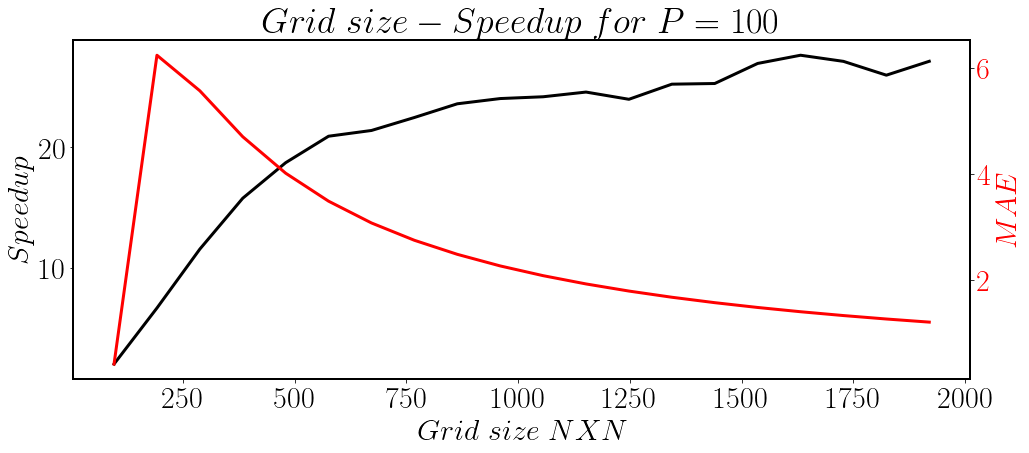

In [50]:
plt.figure(figsize=(15,5))

grid_p = np.array(list(range(1,21)))*96
error_p = [ sample_error[k] for k in sample_error]
adi_time_p =  np.array([adi_time[k].average for k in adi_time ])
prediction_time_p = np.array([ prediction_time[k].average for k in prediction_time])

fig, ax1 = plt.subplots(figsize=(15,7))

ax1.title.set_text(f'$Grid \ size - Speedup \ for \ P = 100$')
ax1.plot(grid_p,adi_time_p/prediction_time_p,'-k',linewidth=3)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylabel('$Speedup$', color='black')
ax1.set_xlabel('$Grid \ size \ NXN$', color='black')
# ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


ax2 = ax1.twinx()  
ax2.set_ylabel('$MAE$', color='red')  
ax2.plot(grid_p, error_p,'-r',linewidth=3)
ax2.tick_params(axis='y', labelcolor='red')
# ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

fig.tight_layout()  # otherwise the right y-label is slightly clipped



plt.savefig(f'SizeSpeedupP=100.svg')

<Figure size 1080x360 with 0 Axes>

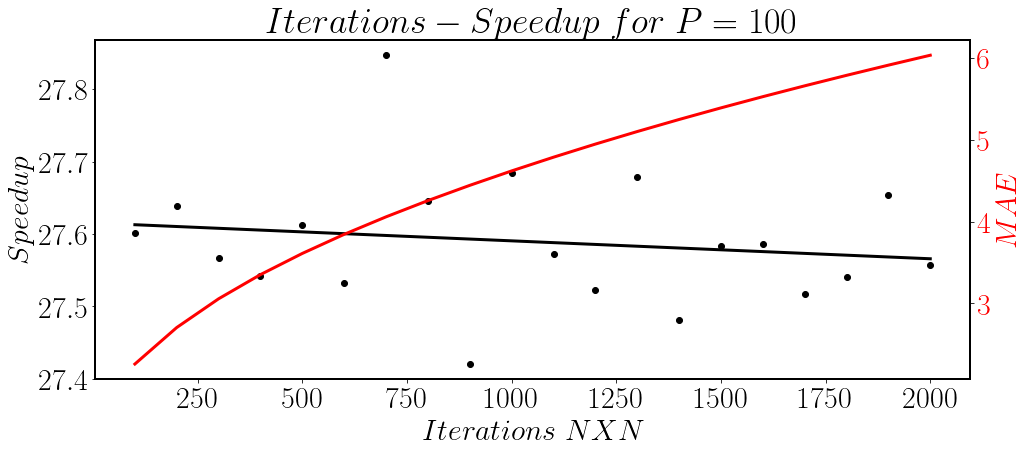

In [65]:
plt.figure(figsize=(15,5))

iterations_p = np.array(list(range(1,21)))*100
error_p = [ sample_error[k] for k in sample_error]
adi_time_p =  np.array([adi_time[k].average for k in adi_time ])
prediction_time_p = np.array([ prediction_time[k].average for k in prediction_time])

m,b = np.polyfit(iterations_p,adi_time_p/prediction_time_p,1)

fig, ax1 = plt.subplots(figsize=(15,7))

ax1.title.set_text(f'$Iterations - Speedup \ for \ P = 100$')
ax1.plot(iterations_p,m*iterations_p+b,'-k',linewidth=3)
ax1.scatter(iterations_p,adi_time_p/prediction_time_p,color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylabel('$Speedup$', color='black')
ax1.set_xlabel('$Iterations \ NXN$', color='black')
# ax1.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


ax2 = ax1.twinx()  
ax2.set_ylabel('$MAE$', color='red')  
ax2.plot(iterations_p, error_p,'-r',linewidth=3)
ax2.tick_params(axis='y', labelcolor='red')
# ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

fig.tight_layout()  # otherwise the right y-label is slightly clipped



plt.savefig(f'IterSpeedupP=100.svg')